---------- point1 1635 ----------
19.091189916052137 21.311797770749713 28.889772978614808 データ数: 50
17.6905778426395 18.803476574644478 23.931765966266966 データ数: 50
9.5 %の確率で極値増加
17.092721562881863 18.760798013208166 24.424434393417357 データ数: 50
16.21280565659829 17.851468545883762 23.980278351333055 データ数: 50
32.6 %の確率で極値増加
---------- point2 1650 ----------
20.231473751946353 21.0065505103658 24.560790766541302 データ数: 50
19.581945437178433 20.51925020985247 23.842253642424833 データ数: 50
34.8 %の確率で極値増加
16.452585802002588 16.66857467369708 17.8853877714734 データ数: 50
18.58637638538827 19.513104649217592 22.81129491076716 データ数: 50
99.9 %の確率で極値増加
---------- point3 2726 ----------
16.226328845329512 17.082097919877185 22.891213089095817 データ数: 50
21.09970254855795 26.080332536093003 53.41462877666102 データ数: 50
99.5 %の確率で極値増加
14.598924391179612 17.689386615107885 42.082066421480945 データ数: 50
15.987277707612858 22.26015847032707 84.79521412671501 データ数: 50
78.8 %の確率で極値増加
---------- point4 3378 ---------

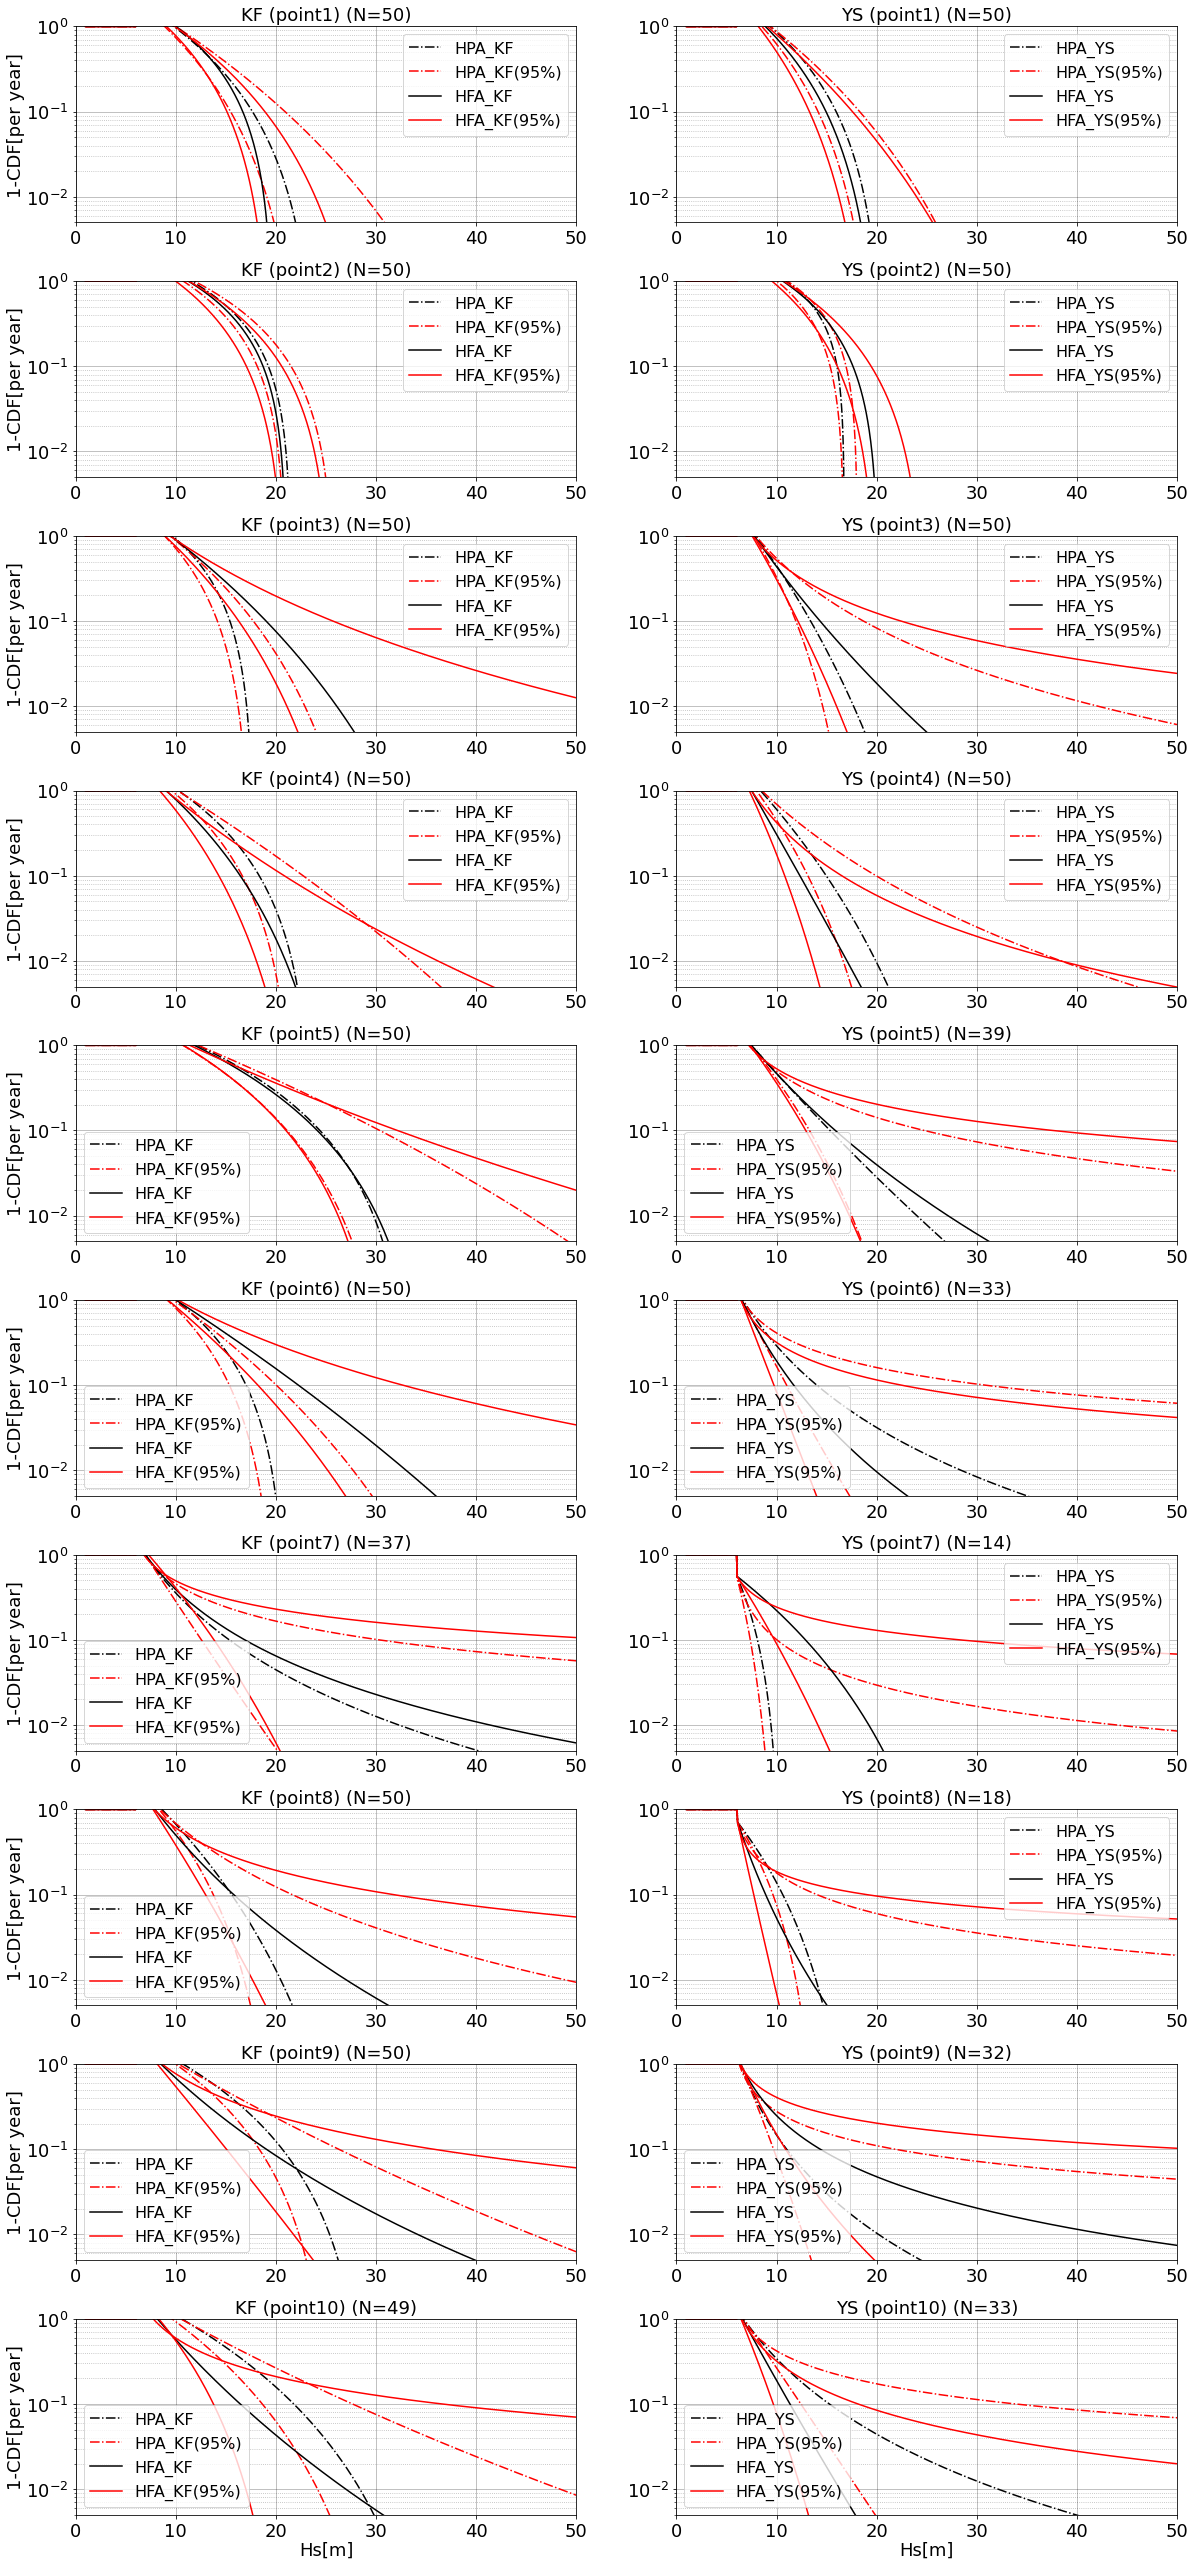

In [6]:
"""
LWMの出力結果を用いて, 極値増大確率の算出とCDFの描画をする.
"""

import func
from csv import reader
import matplotlib.pyplot as plt
import numpy as np

MODEL = ['KF', 'YS']
INDEX = sorted([79*67 + 13, 79*64 + 26, 79*43 + 23, 79*63 + 43, 79*51 + 39, 79*42 + 60, 79*60 + 56, 79*34 + 40, 79*20 + 70, 79*20 + 55])
def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    確率密度関数から, 極値増大確率を算出する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def GP(xi, sgm, y, n0, n):
    """
    GPの1-CDF
    n0:閾値データ数
    n:全データ数
    """
    if y <= 0:
        return 1
    else:
        return (max(0, (1 + xi * y / sgm)) ** (-1/xi)) * n0 * 24 * 365 / n


DATA_CNT = 50

# 描画用の画像を用意
fig = plt.figure(figsize=(18, 36))
for index in range(len(INDEX)):
    idx = INDEX[index]
    print("----------", 'point' + str(index+1), idx, "----------")
    for i in range(2):  # model
        is_ok = True  # データ数がDATA_CNT以上あるかどうかのFlag(なければその地点は使用しない)
        for j in range(2):
            model = MODEL[i]
            # CSV名を指定するためにmodel名を変更
            if j == 0:  # 過去
                model = 'HPA_' + model
            else:  # 未来
                model = 'HFA_' + model + '_c0'
            with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
                csv_reader = reader(csv_file)
                POT_ALL = list(csv_reader)
            POT = POT_ALL[idx] # 指定した場所のPOTを抽出
            # POTは文字列のリストになっているので, float型に変換する
            s = []
            for k in range(len(POT)):
                s.append(float(POT[k]))
            s = sorted(s, reverse=True)
            if len(POT) < 10:
                is_ok = False
            else:
                POT = s[:DATA_CNT]
                u = s[-1]
                
                if j == 0:  # 過去
                    past_rv, past_pro, p_xi, p_sgm= func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=len(POT), con=0.95)
                    u_p = u
                    N_P = len(POT)
                else:  # 将来
                    f_rv, f_pro, f_xi, f_sgm= func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=len(POT), con=0.95)
                    u_f= u
                    N_F = len(POT)
        if is_ok:
            P = calc_p(past_rv, past_pro, f_rv, f_pro)
            print('{:.1f}'.format(P), '%の確率で極値増加')
            ax = fig.add_subplot(len(INDEX), 2, 2 * index + i+1)
            # MLのplot
            x = np.linspace(1, 50, 1000)
            ax.plot(x, [GP(xi=p_xi[1], sgm=p_sgm[1], y=x_ - u_p, n0=len(POT), n=219143) for x_ in x], color='black', linestyle="dashdot", label='HPA_' + model[4:6])
            ax.plot(x, [GP(xi=p_xi[0], sgm=p_sgm[0], y=x_ - u_p, n0=len(POT), n=219143) for x_ in x], color='red', linestyle="dashdot", label='HPA_' + model[4:6] + '(95%)')
            ax.plot(x, [GP(xi=p_xi[2], sgm=p_sgm[2], y=x_ - u_p, n0=len(POT), n=219143) for x_ in x], color='red', linestyle="dashdot")
            ax.plot(x, [GP(xi=f_xi[1], sgm=f_sgm[1], y=x_ - u_f, n0=len(POT), n=219143) for x_ in x], color='black', label=model[:-3])
            ax.plot(x, [GP(xi=f_xi[0], sgm=f_sgm[0], y=x_ - u_f, n0=len(POT), n=219143) for x_ in x], color='red', label=model[:-3] + '(95%)')
            ax.plot(x, [GP(xi=f_xi[2], sgm=f_sgm[2], y=x_ - u_f, n0=len(POT), n=219143) for x_ in x], color='red')
            ax.legend(fontsize=16)
            ax.set_xlim((0, 50))
            ax.set_ylim((0.005, 1))
            if index == len(INDEX) - 1:
                ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
            if i == 0:
                ax.set_ylabel("1-CDF[per year]", fontsize=18, labelpad=1)
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)
            if j == 0:
                ax.set_title(MODEL[i] + ' (point' + str(index+1) + ')' + ' (N=' + str(N_P) + ')', fontsize=18)
            else:
                ax.set_title(MODEL[i] + ' (point' + str(index+1) + ')' + ' (N=' + str(N_F) + ')', fontsize=18)
            ax.set_yscale('log')
            ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
            ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

# plt.subplots_adjust(hspace=0.3)
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.02, top=0.98, hspace=0.3) #この1行を入れる
plt.savefig("../img/1-cdf_for_sum.png")
plt.show()